In [2]:
Sys.setlocale(category = "LC_ALL", locale = "en_US.UTF-8")

[1] "en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/C"

# Dependencies

In [1]:
pacman::p_load(dplyr, ggplot2, ggbeeswarm, ggpubr, ggsignif, cowplot, ggh4x, ggrepel, ComplexHeatmap, lsmeans)

# Functions

In [3]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/Misc_functions.R")

In [4]:
scaleFUN <- function(x) sprintf("%.1f", x)

# Paths

In [5]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [6]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Main

In [7]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [8]:
meta_div <- meta_div[ meta_div$cancergroup != "Normal", ]
meta_div <- meta_div[ meta_div$cancergroup != "LFS", ]

In [9]:
table(meta_div$sampletype, useNA = "always")


cfDNA  PBMC Tumor  <NA> 
  274   534    18     0 

In [10]:
meta_div[ meta_div$Patient == "CHP_390",]

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,estimated_Shannon,SE_Shannon,observed_Simpson,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
657,CHP_390_05,CHP_390,X05,0.0,791.48,5,OS,0.0,2506,307,...,93.728,0.948,80.899,82.940,1.596,CHP_390-05_PBMC-DNA,batch12_30Apr2021/mixcr/clones/CLONES_TRBCHP_390-05_PBMC-DNA.txt,PBMC,CHP,1.9645472
186,CHP_390_02,CHP_390,X02,0.8,913.50,5,OS,0.8,576,1,...,14.514,0.109,8.516,8.519,0.092,CHP_390-02_cfDNA,batch13_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_390-02_cfDNA.txt,cfDNA,CHP,1.1614878
187,CHP_390_03,CHP_390,X03,18.3,NA,5,OS,18.3,2440,186,...,13.179,0.168,10.327,10.350,0.165,CHP_390-03_cfDNA,priority_pool2/mixcr/clones/CLONES_TRBCHP_390-03_cfDNA.txt,cfDNA,CHP,1.1188597
188,CHP_390_04,CHP_390,X04,NA,1096.68,5,OS,NA,0,NA,...,4.370,0.052,3.530,3.532,0.042,CHP_390-04_cfDNA,batch11_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_390-04_cfDNA.txt,cfDNA,CHP,0.6399842
189,CHP_390_05,CHP_390,X05,0.0,791.48,5,OS,0.0,2506,307,...,4.973,0.123,3.931,3.940,0.114,CHP_390-05_cfDNA,cfDNA_Matched_Priority_Pool1_19Nov2021/mixcr/clones/CLONES_TRBCHP_390-05_cfDNA.txt,cfDNA,CHP,0.6950437
653,CHP_390_01,CHP_390,X01,0.8,304.98,5,OS,0.8,2421,5,...,NA,NA,NA,NA,NA,NA,NA,PBMC,CHP,NA
656,CHP_390_04,CHP_390,X04,NA,1096.68,5,OS,NA,0,NA,...,NA,NA,NA,NA,NA,NA,NA,PBMC,CHP,NA
3561,CHP_390_01,CHP_390,X00,0.8,304.98,5,OS,0.8,2421,5,...,1.749,0.031,1.591,1.592,0.037,CHP_390-FFPE-DNA_S9,batchFFPE_3Apr2020/mixcr/clones/CLONES_TRBCHP_390-FFPE-DNA_S9.txt,Tumor,CHP,0.2425414


Separate PBMC and cfDNA

In [10]:
table(meta_div$cancergroup)


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                370                 138                 274                  44 

In [11]:
meta_div <- meta_div[ meta_div$cancergroup != "T-cell malignancies", ]

In [12]:
pbmc <- meta_div[ which(meta_div$sampletype == "PBMC"),]
cfdna <- meta_div[ which(meta_div$sampletype == "cfDNA"),]

### Change relative to with baseline

In [13]:
pbmc <- meta_div[ which(meta_div$sampletype == "PBMC"),]
pbmc <- pbmc[ !is.na(pbmc$TRB),]

In [14]:
pbmc$log10shann_scaled <- scale(pbmc$log10shann)

In [15]:
diff_log10shann <- calculate_delta.fx(pbmc, "cycle", "log10shann_scaled")
diff_log10shann <- diff_log10shann[!is.na(diff_log10shann$Difference), ]

In [16]:
cfdna$log10shann_scaled <- scale(cfdna$log10shann)

In [17]:
diff_log10shann_cfdna <- calculate_delta.fx(cfdna, "cycle", "log10shann_scaled")
diff_log10shann_cfdna <- diff_log10shann_cfdna[ !is.na(diff_log10shann_cfdna$Difference),]

In [18]:
pbmc1 <- meta_div[ meta_div$sampletype == "PBMC" & !is.na(meta_div$CD3),]
pbmc1 <- pbmc1[ pbmc1$CD3 > 0,]

In [19]:
mycells <- c("`Naïve%`", "`SCM%`", "`CM%`", "`EM%`", "`TE%`", "`PD1%`", "`LAG3%`", "`TIM3%`")

In [20]:
for (i in 1:length(mycells)) {
    pbmc1$grp <- gsub("`", "", mycells[i])
    mycol <- paste0("Diff_", gsub("%", "", pbmc1$grp[1]))
    myvar <- paste0("scaled_", gsub("%", "", pbmc1$grp[1]))
    pbmc1[[myvar]] <- NA
    pbmc1[[myvar]] <- scale(pbmc1[[pbmc1$grp[1]]])
    mydiff <- calculate_delta.fx(pbmc1, "cycle", myvar)
    # print(summary(mydiff$Difference))
    pbmc1[[mycol]] <- mydiff$Difference[match(pbmc1$sample_id, mydiff$sample_id)]
}

In [21]:
# pivot_longer
pbmc1_long <- pbmc1 %>%
    select(
        sample_id, Patient, cycle, cancergroup,Disease_type, Age,  Relapse, Diff_Naïve, Diff_SCM, Diff_CM, Diff_EM, Diff_TE,
        Diff_PD1, Diff_LAG3, Diff_TIM3
    ) %>%
    tidyr::pivot_longer(cols = starts_with("Diff_"), names_to = "marker", values_to = "Diff")


In [22]:
pbmc1_long <- pbmc1_long[ !is.na(pbmc1_long$Diff),]

In [23]:
summary(pbmc1$Diff_LAG3[ pbmc1$cancergroup == "Solid tumors" & pbmc1$cycle == "X04"])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-0.2594  0.4236  0.9769  1.3760  2.0998  3.7511       4 

In [24]:
summary(diff_log10shann_cfdna$Difference[diff_log10shann_cfdna$cancergroup == "Lymphoma" &
    diff_log10shann_cfdna$cycle == "X05"])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-3.3303 -1.9151 -1.1965 -1.3386 -0.4972  0.2460 

In [25]:
pbmc1_long$marker <- gsub("Diff_", "", pbmc1_long$marker)
pbmc1_long$marker <- paste0(pbmc1_long$marker, "%")

In [26]:
pbmc1_long_cells <- pbmc1_long[ pbmc1_long$marker %in% c("Naïve%", "SCM%", "CM%", "EM%", "TE%"), ]
pbmc1_long_ic <- pbmc1_long[ pbmc1_long$marker %in% c("PD1%", "LAG3%", "TIM3%"), ]

### Exploratory by cancer type

#### Leu

In [27]:
diff_log10shann$grp <- "TCR Diversity"
diff_log10shann_cfdna$grp <- "cfTCR Diversity"

In [28]:
p_shann_leu <- delta_basespiderplot.fx(
    diff_log10shann[diff_log10shann$cancergroup == "Leukemia", ],
    "cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
)


In [29]:
q_10_90 <- quantile(diff_log10shann$Difference[diff_log10shann$cancergroup == "Leukemia" &
    diff_log10shann$cycle != "X01"], c(0.1, 0.9))


In [30]:
p_shann_leu <- p_shann_leu + theme(legend.position = "none") +
  facet_wrap(~ grp + Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
  theme(
    plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
    axis.title.x = element_blank(),
    legend.position = "none",
    strip.text.x = element_text(size = 13),
    strip.background.x = element_blank(),
    strip.placement = "outside"
  ) +
  ylab("D TCR diversity") +
  scale_x_discrete(get_breaks("cycle"),
    labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
  ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  annotate("ribbon",
    x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
    alpha = 0.3, fill = "light grey"
  ) +
  scale_color_manual(labels = c("No Relapse", "Relapse"), values = c("0" = "blue", "1" = "red"))


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


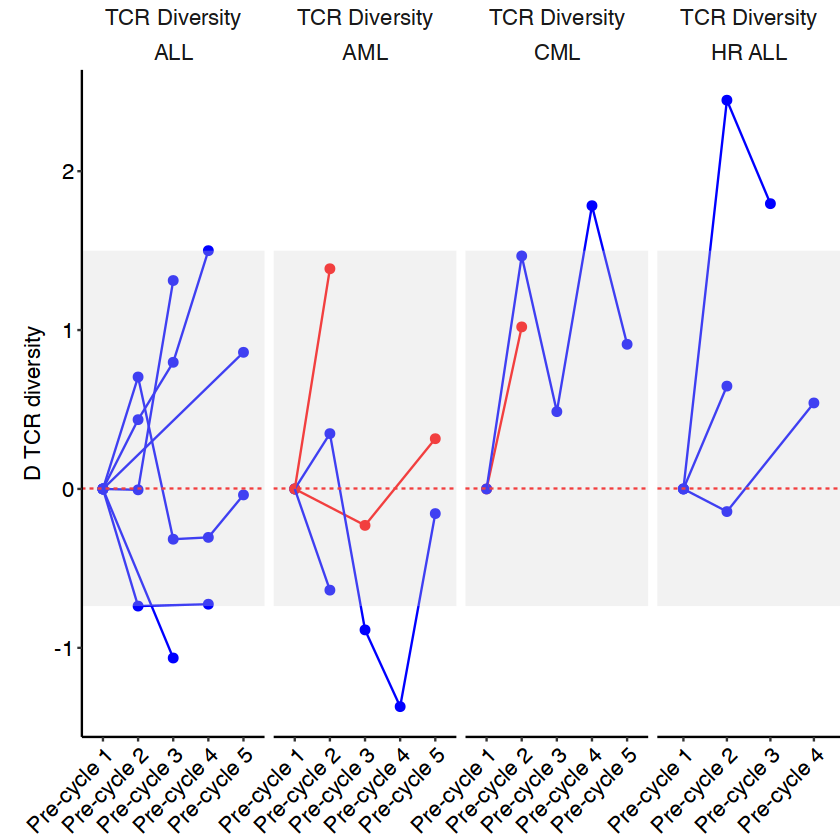

In [31]:
p_shann_leu

In [32]:
p_cfshann_leu <- delta_basespiderplot.fx(
    diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Leukemia", ],
    "cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
)


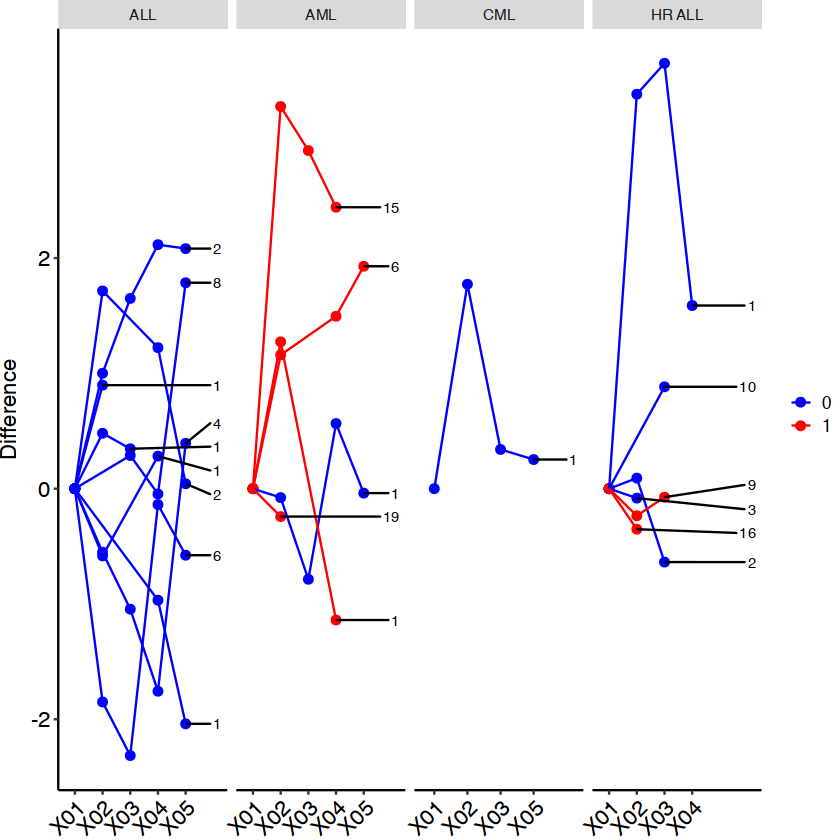

In [33]:
last_timepoint <- diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Leukemia", ] %>%
    group_by(Patient) %>%
    filter(cycle == max(cycle))
last_timepoint$cycleno <- as.numeric(gsub("X0", "", last_timepoint$cycle))

p_cfshann_leu + geom_text_repel(
    data = last_timepoint,
    aes(label = Age),
    hjust = "left",
    direction = "y",
    nudge_x = 6.5 - last_timepoint$cycleno,
    size = 3,
    xlim = c(4, NA),
    segment.color = "black"
) + facet_wrap(~Disease_type, nrow = 1, scales = "free_x", strip.position = "top")


In [34]:
q_10_90 <- quantile(diff_log10shann_cfdna$Difference[diff_log10shann_cfdna$cancergroup == "Leukemia" &
    diff_log10shann_cfdna$cycle != "X01"], c(0.1, 0.9))


In [35]:
p_cfshann_leu <- p_cfshann_leu + theme(legend.position = "none") +
    facet_wrap(~ grp + Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    annotate("ribbon",
        x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
        alpha = 0.3, fill = "light grey"
    )


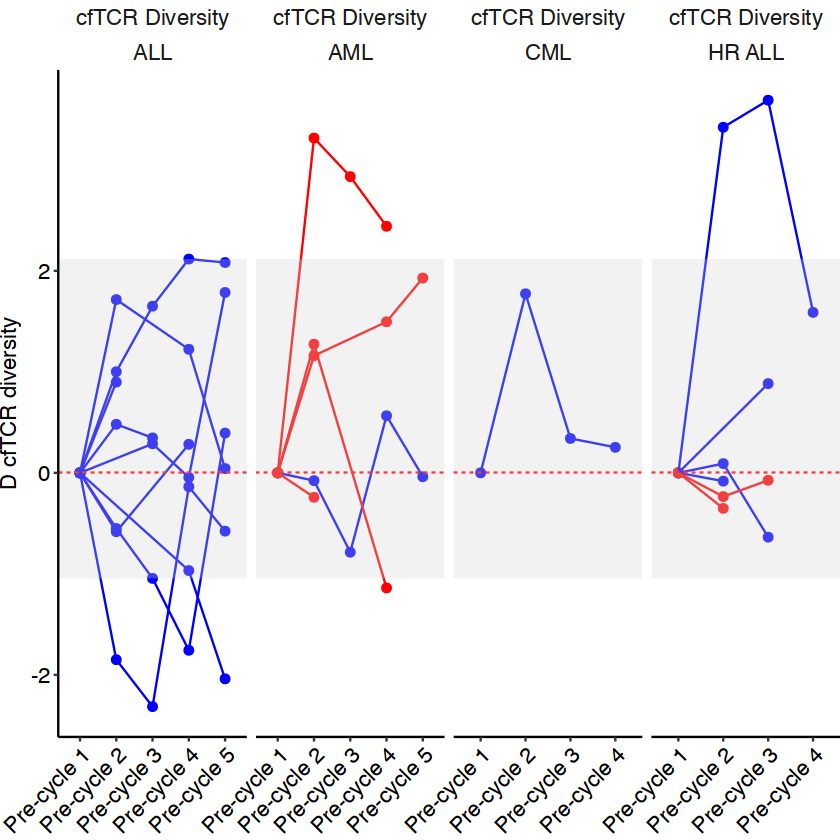

In [36]:
p_cfshann_leu

In [37]:
head(pbmc1_long_cells)

sample_id,Patient,cycle,cancergroup,Disease_type,Age,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,Naïve%,-0.4361997
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,SCM%,0.3956547
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,CM%,0.8951589
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,EM%,0.1928534
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,TE%,-0.4029691
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,0,Naïve%,-0.4251171


In [38]:
pbmc1_long_cells$marker <- factor(pbmc1_long_cells$marker, levels = c("Naïve%", "SCM%", "CM%", "EM%", "TE%"))

In [39]:
cancergroup <- "Leukemia"

mymat <- data.frame(
    "marker" = rep(unique(pbmc1_long_cells$marker[pbmc1_long_cells$cancergroup == cancergroup]), 2),
    "x" = NA, "q10" = NA, "q90" = NA
)

for (i in unique(pbmc1_long_cells$marker)) {
    mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
        pbmc1_long_cells$cycle != "X01" &
        pbmc1_long_cells$marker == i], 0.1)
    mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
        pbmc1_long_cells$cycle != "X01" &
        pbmc1_long_cells$marker == i], 0.9)
    mymat$x[mymat$marker == i] <- c(-Inf, Inf)
}


In [40]:
mymat

marker,x,q10,q90
<fct>,<dbl>,<dbl>,<dbl>
Naïve%,-Inf,-1.9887188,1.6020057
SCM%,-Inf,-0.6644896,0.8929143
CM%,-Inf,-0.9670297,1.9611075
EM%,-Inf,-1.6112239,1.3813240
TE%,-Inf,-2.0867471,1.8420755
Naïve%,Inf,-1.9887188,1.6020057
SCM%,Inf,-0.6644896,0.8929143
CM%,Inf,-0.9670297,1.9611075
EM%,Inf,-1.6112239,1.3813240


In [ ]:
p_leu <- ggplot(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Leukemia", ], aes(x = cycle, y = Diff)) +
    geom_point(aes(color = factor(Relapse)), cex = 2) +
    geom_line(aes(group = Patient, color = factor(Relapse))) +
     scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    myplot +
    myaxis +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
geom_ribbon(data = mymat, 
    aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
  ) +
    facet_wrap(~marker + Disease_type, nrow = 5, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D T-cell subsets") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [ ]:
p_leu

In [ ]:
pdf(paste0(plotpath, "p_leu_spiderplots_disease_type.pdf"), width = 10, height = 13)
cowplot::plot_grid(p_leu)
dev.off()

In [ ]:
cancergroup <- "Leukemia"

mymat <- data.frame(
    "marker" = rep(unique(pbmc1_long_ic$marker[pbmc1_long_ic$cancergroup == cancergroup]), 2),
    "x" = NA, "q10" = NA, "q90" = NA
)

for (i in unique(pbmc1_long_ic$marker)) {
    mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
        pbmc1_long_ic$cycle != "X01" &
        pbmc1_long_ic$marker == i], 0.1)
    mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
        pbmc1_long_ic$cycle != "X01" &
        pbmc1_long_ic$marker == i], 0.9)
    mymat$x[mymat$marker == i] <- c(-Inf, Inf)
}


In [ ]:
p_leu_ic <- ggplot(pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Leukemia", ], aes(x = cycle, y = Diff)) +
    geom_point(aes(color = factor(Relapse)), cex = 2) +
    geom_line(aes(group = Patient, color = factor(Relapse))) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    geom_ribbon(
        data = mymat,
        aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
    ) +
    facet_wrap(~ marker + Disease_type, nrow = 3, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D Immune Checkpoint proteins") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")


In [ ]:
p_leu_ic

In [ ]:
pdf(paste0(plotpath, "p_leu_ic_spiderplots_disease_type.pdf"), width = 10, height = 13)
cowplot::plot_grid(p_leu_ic)
dev.off()


#### Lym

In [ ]:
q_10_90 <- quantile(diff_log10shann$Difference[diff_log10shann$cancergroup == "Lymphoma" &
    diff_log10shann$cycle != "X01"], c(0.1, 0.9))


In [ ]:
p_shann_lym <- delta_basespiderplot.fx(
    diff_log10shann[diff_log10shann$cancergroup == "Lymphoma", ],
    "cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
) + theme(legend.position = "none")

In [ ]:
p_shann_lym <- p_shann_lym + theme(legend.position = "none") +
  facet_wrap(~Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
  theme(
    plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
    axis.title.x = element_blank(),
    legend.position = "none",
    strip.text.x = element_text(size = 13),
    strip.background.x = element_blank(),
    strip.placement = "outside"
  ) +
  ylab("D TCR diversity") +
  scale_x_discrete(get_breaks("cycle"),
    labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5") ) +
      annotate("ribbon",
    x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
    alpha = 0.3, fill = "light grey"
  ) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [ ]:
p_shann_lym

In [ ]:
q_10_90 <- quantile(diff_log10shann_cfdna$Difference[diff_log10shann_cfdna$cancergroup == "Lymphoma" &
    diff_log10shann_cfdna$cycle != "X01"], c(0.1, 0.9))


In [ ]:
p_cfshann_lym <- delta_basespiderplot.fx(
    diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Lymphoma", ],
    "cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
)

In [ ]:
p_cfshann_lym <- p_cfshann_lym + theme(legend.position = "none") +
    facet_wrap(~Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5") ) +
          annotate("ribbon",
    x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
    alpha = 0.3, fill = "light grey"
  ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [ ]:
p_cfshann_lym

In [ ]:
pdf(paste0(plotpath, "p_lym_cftcr_spiderplots_disease_type.pdf"), width = 10, height = 4)
cowplot::plot_grid(p_cfshann_lym)
dev.off()

In [ ]:
cancergroup <- "Lymphoma"

mymat <- data.frame(
    "marker" = rep(unique(pbmc1_long_cells$marker[pbmc1_long_cells$cancergroup == cancergroup]), 2),
    "x" = NA, "q10" = NA, "q90" = NA
)

for (i in unique(pbmc1_long_cells$marker)) {
    mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
        pbmc1_long_cells$cycle != "X01" &
        pbmc1_long_cells$marker == i], 0.1)
    mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
        pbmc1_long_cells$cycle != "X01" &
        pbmc1_long_cells$marker == i], 0.9)
    mymat$x[mymat$marker == i] <- c(-Inf, Inf)
}


In [ ]:
p_lym <- ggplot(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Lymphoma", ], aes(x = cycle, y = Diff)) +
    geom_point(aes(color = factor(Relapse)), cex = 2) +
    geom_line(aes(group = Patient, color = factor(Relapse))) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    myplot +
    myaxis +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
        geom_ribbon(
        data = mymat,
        aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
    ) +
    facet_wrap(~marker + Disease_type, nrow = 5, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D T-cell subsets") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [ ]:
pdf(paste0(plotpath, "p_lym_cells_spiderplots_disease_type.pdf"), width = 10, height = 13)
cowplot::plot_grid(p_lym)
dev.off()

In [ ]:
cancergroup <- "Lymphoma"

mymat <- data.frame(
    "marker" = rep(unique(pbmc1_long_ic$marker[pbmc1_long_ic$cancergroup == cancergroup]), 2),
    "x" = NA, "q10" = NA, "q90" = NA
)

for (i in unique(pbmc1_long_ic$marker)) {
    mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
        pbmc1_long_ic$cycle != "X01" &
        pbmc1_long_ic$marker == i], 0.1)
    mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
        pbmc1_long_ic$cycle != "X01" &
        pbmc1_long_ic$marker == i], 0.9)
    mymat$x[mymat$marker == i] <- c(-Inf, Inf)
}


In [ ]:
p_lym_ic <- ggplot(pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Lymphoma", ], aes(x = cycle, y = Diff)) +
    geom_point(aes(color = factor(Relapse)), cex = 2) +
    geom_line(aes(group = Patient, color = factor(Relapse))) +
    scale_color_manual(values = c("0" = "blue", "1" = "red"))  +
    myplot +
    myaxis +
    theme(plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
        geom_ribbon(
        data = mymat,
        aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
    ) +
    facet_wrap(~marker + Disease_type, nrow = 3, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D Immune Checkpoint proteins") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [ ]:
pdf(paste0(plotpath, "p_lym_ic_spiderplots_disease_type.pdf"), width = 10, height = 6)
cowplot::plot_grid(p_lym_ic)
dev.off()

#### Solid

In [ ]:
q_10_90 <- quantile(diff_log10shann$Difference[diff_log10shann$cancergroup == "Solid tumors" &
    diff_log10shann$cycle != "X01"], c(0.1, 0.9))


In [ ]:
p_shann_solid <- delta_basespiderplot.fx(
    diff_log10shann[diff_log10shann$cancergroup == "Solid tumors", ],
    "cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
) + theme(legend.position = "none")

In [ ]:
p_shann_solid <- p_shann_solid + theme(legend.position = "none") +
  facet_wrap(~Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
  theme(plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
    axis.title.x = element_blank(),
    legend.position = "none",
    strip.text.x = element_text(size = 13),
    strip.background.x = element_blank(),
    strip.placement = "outside"
  ) +
  ylab("D TCR diversity") +
  scale_x_discrete(get_breaks("cycle"),
    labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5") ) +
      annotate("ribbon",
    x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
    alpha = 0.3, fill = "light grey"
  ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [ ]:
p_shann_solid

In [ ]:
q_10_90 <- quantile(diff_log10shann_cfdna$Difference[diff_log10shann_cfdna$cancergroup == "Solid tumors" &
    diff_log10shann_cfdna$cycle != "X01"], c(0.1, 0.9))


In [ ]:
p_cfshann_solid <- delta_basespiderplot.fx(
    diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Solid tumors", ],
    "cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
)

In [ ]:
p_cfshann_solid <- p_cfshann_solid + theme(legend.position = "none") +
    facet_wrap(~Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + 
      annotate("ribbon",
    x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
    alpha = 0.3, fill = "light grey"
  ) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [ ]:
p_cfshann_solid

In [ ]:
cancergroup <- "Solid tumors"

mymat <- data.frame(
    "marker" = rep(unique(pbmc1_long_cells$marker[pbmc1_long_cells$cancergroup == cancergroup]), 2),
    "x" = NA, "q10" = NA, "q90" = NA
)

for (i in unique(pbmc1_long_cells$marker)) {
    mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
        pbmc1_long_cells$cycle != "X01" &
        pbmc1_long_cells$marker == i], 0.1)
    mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
        pbmc1_long_cells$cycle != "X01" &
        pbmc1_long_cells$marker == i], 0.9)
    mymat$x[mymat$marker == i] <- c(-Inf, Inf)
}


In [ ]:
p_solid <- ggplot(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Solid tumors", ], aes(x = cycle, y = Diff)) +
    geom_point(aes(color = factor(Relapse)), cex = 2) +
    geom_line(aes(group = Patient, color = factor(Relapse))) +
    scale_color_manual( values = c("0" = "blue", "1" = "red"))  +
    myplot +
    myaxis +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
        geom_ribbon(
        data = mymat,
        aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
    ) +
    facet_wrap(~marker+ Disease_type, nrow = 5, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D T-cell subsets") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [ ]:
p_solid

In [ ]:
pdf(paste0(plotpath, "p_solid_cells_spiderplots_disease_type.pdf"), width = 10, height = 13)
cowplot::plot_grid(p_solid)
dev.off()

In [ ]:
cancergroup <- "Solid tumors"

mymat <- data.frame(
    "marker" = rep(unique(pbmc1_long_ic$marker[pbmc1_long_ic$cancergroup == cancergroup]), 2),
    "x" = NA, "q10" = NA, "q90" = NA
)

for (i in unique(pbmc1_long_ic$marker)) {
    mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
        pbmc1_long_ic$cycle != "X01" &
        pbmc1_long_ic$marker == i], 0.1)
    mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
        pbmc1_long_ic$cycle != "X01" &
        pbmc1_long_ic$marker == i], 0.9)
    mymat$x[mymat$marker == i] <- c(-Inf, Inf)
}


In [ ]:
p_solid_ic <- ggplot(pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Solid tumors", ], aes(x = cycle, y = Diff)) +
    geom_point(aes(color = factor(Relapse)), cex = 2) +
    geom_line(aes(group = Patient, color = factor(Relapse))) +
    scale_color_manual(values = c("0" = "blue", "1" = "red"))  +
    myplot +
    myaxis +
    theme(plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
        axis.text.x = element_blank(),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
        geom_ribbon(
        data = mymat,
        aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
    ) +
    facet_wrap(~marker+Disease_type, nrow = 3, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D Immune Checkpoint proteins") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [ ]:
pdf(paste0(plotpath, "p_solid_ic_spiderplots_disease_type.pdf"), width = 10, height = 8)
cowplot::plot_grid(p_solid_ic)
dev.off()


## Specific observations

Leu

In [41]:
head(pbmc1_long_cells)

sample_id,Patient,cycle,cancergroup,Disease_type,Age,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<dbl>
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,Naïve%,-0.4361997
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,SCM%,0.3956547
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,CM%,0.8951589
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,EM%,0.1928534
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,TE%,-0.4029691
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,0,Naïve%,-0.4251171


In [42]:
pbmc1_long_cells$marker <- as.character(pbmc1_long_cells$marker)

In [43]:
tmp1 <- pbmc1_long_cells[pbmc1_long_cells$Disease_type %in% c("ALL", "HR ALL") &
    pbmc1_long_cells$marker %in% c("Naïve%", "CM%"), ]

In [44]:
tmp1$marker <- factor(tmp1$marker, levels = c("Naïve%", "CM%"))

In [49]:
tmp1[ tmp1$marker == "CM%",]

sample_id,Patient,cycle,cancergroup,Disease_type,Age,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<fct>,<dbl>
CHP_347_01,CHP_347,X01,Leukemia,ALL,13,0,CM%,0.000000000
CHP_347_02,CHP_347,X02,Leukemia,ALL,13,0,CM%,0.468484512
CHP_347_03,CHP_347,X03,Leukemia,ALL,13,0,CM%,2.364981208
CHP_347_04,CHP_347,X04,Leukemia,ALL,13,0,CM%,3.836434463
CHP_347_05,CHP_347,X05,Leukemia,ALL,13,0,CM%,0.032589433
CHP_367_01,CHP_367,X01,Leukemia,HR ALL,14,0,CM%,0.000000000
CHP_373_01,CHP_373,X01,Leukemia,ALL,2,0,CM%,0.000000000
CHP_378_01,CHP_378,X01,Leukemia,ALL,1,0,CM%,0.000000000
CHP_378_04,CHP_378,X04,Leukemia,ALL,1,0,CM%,-0.007732284


In [47]:
cancergroup <- "Leukemia"

mymat <- data.frame(
    "marker" = rep(unique(tmp1$marker[tmp1$cancergroup == cancergroup]), 2),
    "x" = NA, "q10" = NA, "q90" = NA
)

for (i in unique(tmp1$marker)) {
    mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
        pbmc1_long_cells$cycle != "X01" &
        pbmc1_long_cells$marker == i], 0.1)
    mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
        pbmc1_long_cells$cycle != "X01" &
        pbmc1_long_cells$marker == i], 0.9)
    mymat$x[mymat$marker == i] <- c(-Inf, Inf)
}

In [48]:
mymat

marker,x,q10,q90
<fct>,<dbl>,<dbl>,<dbl>
Naïve%,-Inf,-1.9887188,1.602006
CM%,-Inf,-0.9670297,1.961108
Naïve%,Inf,-1.9887188,1.602006
CM%,Inf,-0.9670297,1.961108


In [ ]:
p_leu <- ggplot(tmp1, aes(x = cycle, y = Diff)) +
    geom_point(aes(color = factor(Relapse)), cex = 2) +
    geom_line(aes(group = Patient, color = factor(Relapse))) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    geom_ribbon(
        data = mymat,
        aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
    ) +
    ggh4x::facet_wrap2(~ marker + Disease_type, axes = "all", remove_labels = "all") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside",
        axis.line = element_line(colour = "black")
    ) +
    ylab("D T-cell subsets") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")


In [ ]:
p_leu

In [ ]:
pdf(paste0(plotpath, "p_ALL_HRALL_Naive_CM.pdf"), width = 4, height = 6)
cowplot::plot_grid(p_leu, labels = "A")
dev.off()

In [50]:
tmp2 <- diff_log10shann_cfdna[diff_log10shann_cfdna$Disease_type %in% c("ALL", "HR ALL", "AML"), ]

In [55]:
tmp2[ tmp2$Difference < -1,]

sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann,log10shann_scaled,Difference,grp
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<chr>
CHP_360_02,CHP_360,X02,0.0,75.24,6,ALL,0.0,0,NA,...,2.439,0.253,CHP_360-02-cfDNA,batch1_cfDNA_30Jan2020/mixcr/clones/CLONES_TRBCHP_360-02-cfDNA.txt,cfDNA,CHP,0.5120170,-0.2969668,-1.849652,cfTCR Diversity
CHP_360_03,CHP_360,X03,0.0,0.00,6,ALL,0.0,0,NA,...,1.830,0.020,CHP_360-03_cfDNA,remaining_batch_2_cfDNA_15April2021/mixcr/clones/CLONES_TRBCHP_360-03_cfDNA.txt,cfDNA,CHP,0.3087778,-0.7618315,-2.314516,cfTCR Diversity
CHP_376_04,CHP_376,X04,0.0,0.00,1,AML,0.0,0,NA,...,1.000,0.000,CHP_376-04_cfDNA,remaining_batch_2_cfDNA_15April2021/mixcr/clones/CLONES_TRBCHP_376-04_cfDNA.txt,cfDNA,CHP,0.0000000,-1.4680923,-1.139144,cfTCR Diversity
CHP_378_05,CHP_378,X05,1.1,0.00,1,ALL,1.1,2573,34,...,2.091,0.012,CHP_378-05_cfDNA,remaining_batch_4_cfDNA_15April2021/mixcr/clones/CLONES_TRBCHP_378-05_cfDNA.txt,cfDNA,CHP,0.3911116,-0.5735111,-2.039340,cfTCR Diversity
CHP_388_03,CHP_388,X03,18.0,254.98,4,ALL,18.0,2457,4,...,2.987,0.066,CHP_388-03_cfDNA,cfDNA_Matched_Priority_Pool1_19Nov2021/mixcr/clones/CLONES_TRBCHP_388-03_cfDNA.txt,cfDNA,CHP,0.5751878,-0.1524775,-1.044704,cfTCR Diversity
CHP_388_04,CHP_388,X04,26.5,0.00,4,ALL,26.5,1303,0,...,1.695,0.018,CHP_388-04_cfDNA,batch11_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_388-04_cfDNA.txt,cfDNA,CHP,0.2638727,-0.8645420,-1.756769,cfTCR Diversity


In [52]:
p_cfshann_leu <- delta_basespiderplot.fx(
    tmp2,"cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
)

In [53]:
q_10_90 <- quantile(diff_log10shann_cfdna$Difference[diff_log10shann_cfdna$cancergroup == "Leukemia" &
    diff_log10shann_cfdna$cycle != "X01"], c(0.1, 0.9))

In [54]:
q_10_90

10%       90% 
-1.044704  2.116682

In [ ]:
p_cfshann_leu <- p_cfshann_leu + theme(legend.position = "none") +
    ggh4x::facet_wrap2(~ grp + Disease_type, axes = "all", remove_labels = "all") +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    annotate("ribbon",
        x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
        alpha = 0.3, fill = "light grey"
    )


In [ ]:
p_cfshann_leu

In [ ]:
pdf(paste0(plotpath, "p_ALL_HRALL_AML_cfTCR.pdf"), width = 6, height = 3)
cowplot::plot_grid(p_cfshann_leu, labels = "B")
dev.off()

Lym

In [ ]:
table(diff_log10shann_cfdna$Disease_type)

In [56]:
tmp3 <- diff_log10shann_cfdna[diff_log10shann_cfdna$Disease_type %in% c("BL", "HD"), ]

In [57]:
p_cfshann_lym <- delta_basespiderplot.fx(
    tmp3,"cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
)

In [58]:
q_10_90 <- quantile(diff_log10shann_cfdna$Difference[diff_log10shann_cfdna$cancergroup == "Lymphoma" &
    diff_log10shann_cfdna$cycle != "X01"], c(0.1, 0.9))

In [59]:
q_10_90

10%        90% 
-3.1081836 -0.1767293

In [ ]:
p_cfshann_lym <- p_cfshann_lym + theme(legend.position = "none") +
    ggh4x::facet_wrap2(~ grp + Disease_type, axes = "all", remove_labels = "all") +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    annotate("ribbon",
        x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
        alpha = 0.3, fill = "light grey"
    )


In [ ]:
p_cfshann_lym

In [ ]:
pdf(paste0(plotpath, "p_BL_HD_cfTCR.pdf"), width = 4, height = 3)
cowplot::plot_grid(p_cfshann_lym, labels = "C")
dev.off()

Solid

In [27]:
head(pbmc1_long_cells)

sample_id,Patient,cycle,cancergroup,Disease_type,Age,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,Naïve%,-0.4361997
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,SCM%,0.3956547
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,CM%,0.8951589
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,EM%,0.1928534
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,TE%,-0.4029691
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,0,Naïve%,-0.4251171


In [28]:
pbmc1_long_cells$marker <- as.character(pbmc1_long_cells$marker)

In [29]:
tmp4 <- pbmc1_long_cells[pbmc1_long_cells$Disease_type %in% c("ERMS", "EWS", "HB", "NB", "RMS") &
    pbmc1_long_cells$marker == "CM%", ]

In [30]:
cancergroup <- "Solid tumors"

mymat <- data.frame(
    "marker" = rep(unique(tmp4$marker[tmp4$cancergroup == cancergroup]), 2),
    "x" = NA, "q10" = NA, "q90" = NA
)

mymat$q10[mymat$marker == "CM%"] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
    pbmc1_long_cells$cycle != "X01" &
    pbmc1_long_cells$marker == "CM%"], 0.1)
mymat$q90[mymat$marker == "CM%"] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
    pbmc1_long_cells$cycle != "X01" &
    pbmc1_long_cells$marker == "CM%"], 0.9)
mymat$x[mymat$marker == "CM%"] <- c(-Inf, Inf)


In [31]:
mymat

marker,x,q10,q90
<chr>,<dbl>,<dbl>,<dbl>
CM%,-Inf,-0.3384162,1.897802
CM%,Inf,-0.3384162,1.897802


In [32]:
tmp4

sample_id,Patient,cycle,cancergroup,Disease_type,Age,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,CM%,0.89515885
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,0,CM%,4.38779612
CHP_343_04,CHP_343,X04,Solid tumors,EWS,8,0,CM%,2.27388641
CHP_343_05,CHP_343,X05,Solid tumors,EWS,8,0,CM%,1.11083531
CHP_350_01,CHP_350,X01,Solid tumors,HB,1,0,CM%,0.00000000
CHP_350_02,CHP_350,X02,Solid tumors,HB,1,0,CM%,-0.07409058
CHP_350_03,CHP_350,X03,Solid tumors,HB,1,0,CM%,-0.13094725
CHP_350_04,CHP_350,X04,Solid tumors,HB,1,0,CM%,0.25815024
CHP_350_05,CHP_350,X05,Solid tumors,HB,1,0,CM%,0.61368937


In [33]:
p_solid <- ggplot(tmp4, aes(x = cycle, y = Diff)) +
    geom_point(aes(color = factor(Relapse)), cex = 2) +
    geom_line(aes(group = Patient, color = factor(Relapse))) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    geom_ribbon(
        data = mymat,
        aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
    ) +
    ggh4x::facet_wrap2(~ marker + Disease_type,nrow = 1, axes = "all", remove_labels = "all") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside",
        axis.line = element_line(colour = "black")
    ) +
    ylab("D T-cell subsets") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")


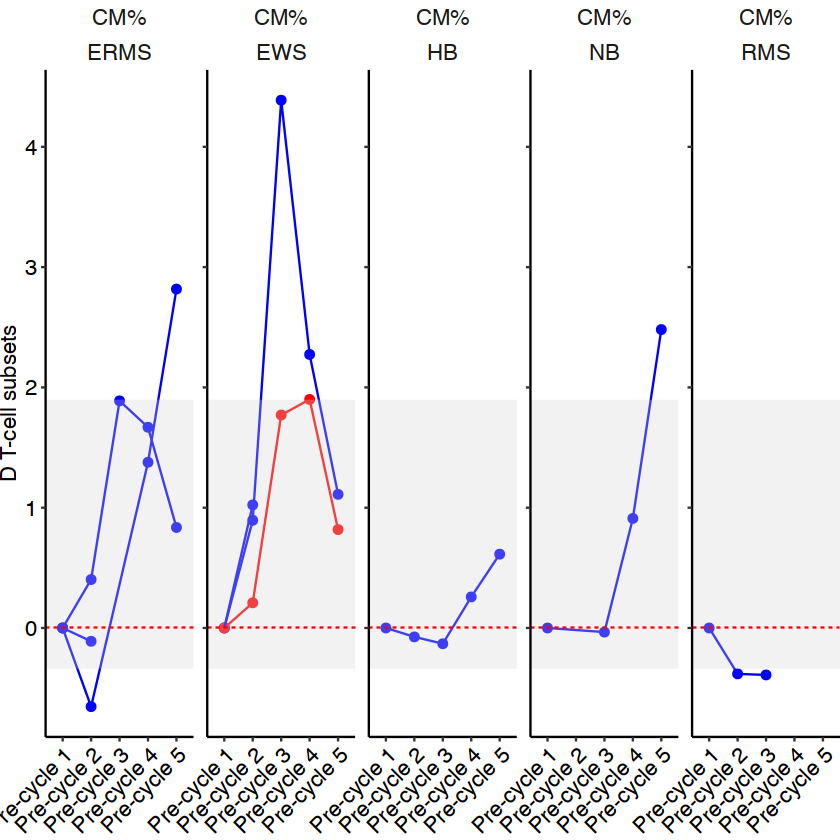

In [34]:
p_solid 

In [81]:
pdf(paste0(plotpath, "p_HB_NB_EWS_ERMS_WIL_RMS_CM.pdf"), width = 12, height = 3)
cowplot::plot_grid(p_solid, labels = "D")
dev.off()

pdf 
  2

In [35]:
head(pbmc1_long_ic)

sample_id,Patient,cycle,cancergroup,Disease_type,Age,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,PD1%,0.2637392
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,LAG3%,2.4206861
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,0,TIM3%,0.2605652
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,0,PD1%,1.7403084
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,0,LAG3%,0.2029807
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,0,TIM3%,1.7193643


In [36]:
tmp6 <- pbmc1_long_ic[pbmc1_long_ic$Disease_type %in% c("ERMS", "OS", "HB") &
    pbmc1_long_ic$marker %in% c("PD1%", "LAG3%"), ]

In [37]:
head(tmp6)

sample_id,Patient,cycle,cancergroup,Disease_type,Age,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>
CHP_348_01,CHP_348,X01,Solid tumors,OS,18,0,PD1%,0.0000000
CHP_348_01,CHP_348,X01,Solid tumors,OS,18,0,LAG3%,0.0000000
CHP_348_02,CHP_348,X02,Solid tumors,OS,18,0,PD1%,1.0906355
CHP_348_02,CHP_348,X02,Solid tumors,OS,18,0,LAG3%,0.4597833
CHP_350_01,CHP_350,X01,Solid tumors,HB,1,0,PD1%,0.0000000
CHP_350_01,CHP_350,X01,Solid tumors,HB,1,0,LAG3%,0.0000000


In [38]:
cancergroup <- "Solid tumors"

mymat <- data.frame(
    "marker" = rep(unique(tmp6$marker[tmp6$cancergroup == cancergroup]), 2),
    "x" = NA, "q10" = NA, "q90" = NA
)

for(i in unique(tmp6$marker)){
mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
    pbmc1_long_ic$cycle != "X01" &
    pbmc1_long_ic$marker == i], 0.1)
mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
    pbmc1_long_ic$cycle != "X01" &
    pbmc1_long_ic$marker == i], 0.9)
mymat$x[mymat$marker == i] <- c(-Inf, Inf)
}


In [39]:
mymat

marker,x,q10,q90
<chr>,<dbl>,<dbl>,<dbl>
PD1%,-Inf,-0.1181702,1.959225
LAG3%,-Inf,-0.3627703,1.839348
PD1%,Inf,-0.1181702,1.959225
LAG3%,Inf,-0.3627703,1.839348


In [ ]:
p_s_ic <- ggplot(tmp6, aes(x = cycle, y = Diff)) +
    geom_point(aes(color = factor(Relapse)), cex = 2) +
    geom_line(aes(group = Patient, color = factor(Relapse))) +
    scale_color_manual(values = c("0" = "blue", "1" = "red")) +
    myplot +
    myaxis +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    ggh4x::facet_wrap2(~ marker + Disease_type, nrow = 2, axes = "all", remove_labels = "all") +
    geom_ribbon(
        data = mymat,
        aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
    ) +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside",
        axis.line = element_line(colour = "black")
    ) +
    ylab("D T-cell subsets") +
    scale_x_discrete(get_breaks("cycle"),
        labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")


In [ ]:
p_s_ic #+   annotate("segment", x=-Inf, xend=Inf, y=-Inf, yend=-Inf)

In [ ]:
pdf(paste0(plotpath, "p_HB_ERMS_OS_PD1_LAG3.pdf"), width = 6, height = 6)
cowplot::plot_grid(p_s_ic, labels = "E")
dev.off()